In [62]:
from pyspark import SparkConf,SparkContext
from pyspark import mllib as ml
from pyspark.ml.feature import Tokenizer,HashingTF,IDF,StopWordsRemover,CountVectorizer
from pyspark.sql import SparkSession,SQLContext,Row
from pyspark.sql.functions import lower,regexp_replace,trim
from textblob import TextBlob
import string
import re
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType,ArrayType
import matplotlib.pyplot as plt
%matplotlib inline  
import pandas as pd

In [ ]:
#Configuring the Spark system, Master = local system.
conf = SparkConf().setMaster("local").setAppName("Project")
sc = SparkContext(conf=conf)

In [63]:
#Applying SQLContext to the Spark Context.
sqlcontext = SQLContext(sc)

In [64]:
#Starting a Spark Session
spark = SparkSession(sqlcontext)

In [65]:
#Reading the twitter data file for verizon
tweets = spark.read.csv("final_tweets.csv",header=True)

# Data Cleaning and Preprocessing

In [66]:
## comverting the tweets to lowercase
verizon_tweets=tweets.withColumn('Text',lower(tweets['Text']))

In [67]:
#remove puntuations
def punc(tweets):
    tweet = re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', '',tweets)
    return tweet
udf_func = udf(punc)

In [68]:
## Removing the punctuations using user defined functions
verizon_tweets = verizon_tweets.withColumn('Text',udf_func(verizon_tweets['Text']))

In [69]:
verizon_tweets.show(2)

+---+------------+-----+--------------------+
|_c0|    Category|Label|                Text|
+---+------------+-----+--------------------+
|  0|Poor service|    4|vzwsupport give m...|
|  1|Poor service|    4|verizon my daught...|
+---+------------+-----+--------------------+
only showing top 2 rows



In [70]:
#Word Tokenization
tokenizer = Tokenizer(inputCol='Text',outputCol='words')
verizon_tweets = tokenizer.transform(verizon_tweets)

In [71]:
#Removing the stop words
stopremover= StopWordsRemover(inputCol='words',outputCol='words_nostopwords')
verizon_tweets = stopremover.transform(verizon_tweets)

In [72]:
verizon_tweets.show(3)

+---+------------+-----+--------------------+--------------------+--------------------+
|_c0|    Category|Label|                Text|               words|   words_nostopwords|
+---+------------+-----+--------------------+--------------------+--------------------+
|  0|Poor service|    4|vzwsupport give m...|[vzwsupport, give...|[vzwsupport, give...|
|  1|Poor service|    4|verizon my daught...|[verizon, my, dau...|[verizon, daughte...|
|  2|Poor service|    4|verizon  customer...|[verizon, , custo...|[verizon, , custo...|
+---+------------+-----+--------------------+--------------------+--------------------+
only showing top 3 rows



In [73]:
#Lemmatization
from nltk.stem import PorterStemmer,WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [74]:
#Bringing back the words to its root form.
def lemmas(words):
    for w in range(0,len(words)):
        words[w] = lemmatizer.lemmatize(words[w],pos='v')
        words[w] = lemmatizer.lemmatize(words[w],pos='a')
    return words

my_func1 = udf(lemmas,ArrayType(StringType()))

In [75]:
verizon_tweets = verizon_tweets.withColumn('words_nostopwords',my_func1(verizon_tweets['words_nostopwords']))

# Data Exploration

In [76]:
df1 = verizon_tweets.toPandas()

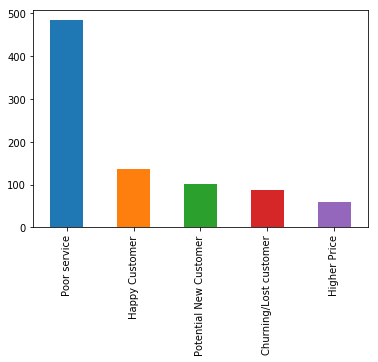

In [77]:
df1['Category'].value_counts().plot('bar')

In [23]:
df2 = verizon_tweets.groupBy('Category').count().toPandas()

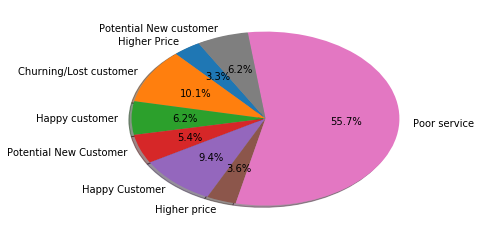

In [49]:
#Pie chart to show the split of the tweet categories for verizon
plt.pie(df2['count'], labels=df2['Category'], autopct='%1.1f%%', shadow=True, startangle=120)
plt.rcParams['figure.figsize'] = 6,5
plt.show()

In [47]:
#Word Cloud
import wordcloud
from wordcloud import WordCloud, STOPWORDS

ModuleNotFoundError: No module named 'wordcloud'

# Overall Sentiments of the tweets

In [78]:
#Sentiment analysis 
def sentiment_analysis(text):
    temp = TextBlob(text)
    if(temp.sentiment.polarity > 0):
        return "positive"
    elif(temp.sentiment.polarity < 0):
        return "negative"
    else:
        return "neutral"

In [79]:
Blob_udf = udf(sentiment_analysis)
verizon_tweets = verizon_tweets.withColumn('sentiment_polarity',Blob_udf(verizon_tweets['Text']))

In [80]:
df1 = verizon_tweets.toPandas()

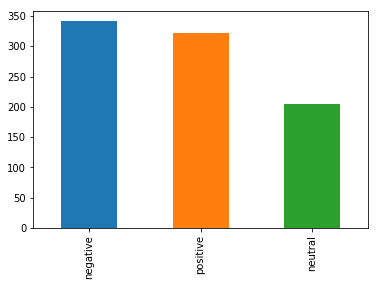

In [81]:
df1['sentiment_polarity'].value_counts().plot('bar')

# Term-Frequency and Inverse Document Frequency

In [30]:
## TF-IDF
hashingTF = HashingTF(inputCol="words_nostopwords", outputCol="rawFeatures", numFeatures=11000)
featurizedData = hashingTF.transform(verizon_tweets)


In [31]:
idf = IDF(inputCol="rawFeatures", outputCol="features")

In [32]:
idfmodel = idf.fit(featurizedData)

In [33]:
rescaled_data = idfmodel.transform(featurizedData)

In [34]:
#classifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer,VectorIndexer,VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import DoubleType,ArrayType,StringType

In [35]:
rescaled_data= rescaled_data.withColumn('label',rescaled_data['label'].cast(DoubleType()))

In [36]:
final_data= rescaled_data.select('label','features')

In [37]:
rf = RandomForestClassifier(featuresCol="features",labelCol="label")

In [38]:
final_data.dtypes

[('label', 'double'), ('features', 'vector')]

# Model Building and Prediction

In [39]:
## Training and test split
(trainingData, testData) = final_data.randomSplit([0.9, 0.1])

In [40]:
## Fit the model on the training data
model = rf.fit(trainingData)

In [41]:
pred = model.transform(testData)

In [52]:
pred.show(10)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  1.0|(11000,[222,372,8...|[0.0,1.8972048067...|[0.0,0.0948602403...|       4.0|
|  1.0|(11000,[268,728,1...|[0.0,2.2664499864...|[0.0,0.1133224993...|       4.0|
|  1.0|(11000,[362,768,1...|[0.0,2.3587864515...|[0.0,0.1179393225...|       4.0|
|  1.0|(11000,[382,594,1...|[0.0,1.5385343604...|[0.0,0.0769267180...|       4.0|
|  1.0|(11000,[520,1086,...|[0.0,2.1489714764...|[0.0,0.1074485738...|       4.0|
|  1.0|(11000,[2599,3874...|[0.0,1.7166494053...|[0.0,0.0858324702...|       4.0|
|  1.0|(11000,[4305,5751...|[0.0,1.8421554781...|[0.0,0.0921077739...|       4.0|
|  1.0|(11000,[6036,1064...|[0.0,1.8421554781...|[0.0,0.0921077739...|       4.0|
|  2.0|(11000,[92,372,11...|[0.0,1.7731346114...|[0.0,0.0886567305...|       4.0|
|  2.0|(11000,[1

In [42]:
#Accuracy of the model 